# Bot classifier

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.externals import joblib
from sklearn import model_selection, linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

import missingno as msno

In [10]:
full = pd.read_csv('data/bot_or_not/train.csv')

In [11]:
full.columns

Index(['avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'contributors_enabled',
       'created_at', 'default_profile', 'default_profile_image', 'description',
       'favourites_count', 'follow_request_sent', 'followers_count',
       'following', 'freq', 'friends_count', 'geo_enabled', 'is_translator',
       'lang', 'listed_count', 'location', 'max_fav', 'max_hash', 'max_len',
       'max_ret', 'media_perc', 'min_fav', 'min_hash', 'min_len', 'min_ret',
       'name', 'notifications', 'profile_background_color',
       'profile_background_image_url', 'profile_background_image_url_https',
       'profile_background_tile', 'profile_image_url',
       'profile_image_url_https', 'profile_link_color',
       'profile_sidebar_border_color', 'profile_sidebar_fill_color',
       'profile_text_color', 'profile_use_background_image', 'protected',
       'quote_perc', 'ret_perc', 'screen_name', 'statuses_count', 'target',
       'time_zone', 'tweet_intradistance', 'url', 'url_intradistance',
      

## Data exploration

In [12]:
full.describe()

,avg_fav,avg_hash,avg_len,avg_ret,favourites_count,followers_count,freq,friends_count,listed_count,max_fav,...,min_hash,min_len,min_ret,quote_perc,ret_perc,target,tweet_intradistance,url_intradistance,url_perc,utc_offset
count,15455.000000,15455.000000,15455.000000,15455.000000,15452.000000,1.545500e+04,15455.000000,1.545200e+04,15452.000000,15455.000000,...,15455.000000,15455.000000,15455.000000,15455.000000,15455.000000,15449.000000,15455.000000,15455.000000,15455.000000,1727.000000
mean,3.097362,0.341198,81.059805,1640.245521,3825.046596,1.888063e+04,4.144654,3.594335e+03,174.087108,82.717114,...,2.658234,22.498350,6.152572,0.041623,0.178269,0.504175,10.358458,4.148089,0.313607,-4839.258830
std,59.237195,0.738631,44.619469,6054.541872,17167.937826,6.440631e+05,11.945211,2.891204e+04,1311.388046,2652.209490,...,3.149491,23.675631,434.279664,0.080563,0.266270,0.499999,4.774776,3.448895,0.350897,22380.037587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-39600.000000
25%,0.010000,0.000000,64.105000,0.020000,2.000000,1.680000e+02,0.063291,1.950000e+02,2.000000,1.000000,...,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,10.412994,0.000000,0.000000,-25200.000000
50%,0.112500,0.100000,87.210000,1.420000,126.500000,7.410000e+02,0.312500,5.580000e+02,16.000000,3.000000,...,2.000000,18.000000,0.000000,0.000000,0.030000,1.000000,11.846343,3.789063,0.163265,-14400.000000
75%,0.500000,0.363636,108.186774,534.690000,1466.000000,3.265500e+03,2.152174,1.759000e+03,81.250000,8.000000,...,4.000000,29.000000,0.000000,0.050000,0.260870,1.000000,13.062085,7.078027,0.540000,18000.000000
max,3372.340000,20.000000,299.180000,294528.510000,543756.000000,7.636714e+07,100.000000,3.003918e+06,107815.000000,234334.000000,...,88.000000,279.000000,49064.000000,1.000000,1.000000,1.000000,24.269322,9.899020,1.000000,46800.000000


Delete naive features 

In [13]:
full = full.drop(columns=['contributors_enabled', 'follow_request_sent', 'following', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_image_url', 'profile_image_url_https', 'time_zone', 'utc_offset'])

plot missing values

In [14]:
features = full.columns

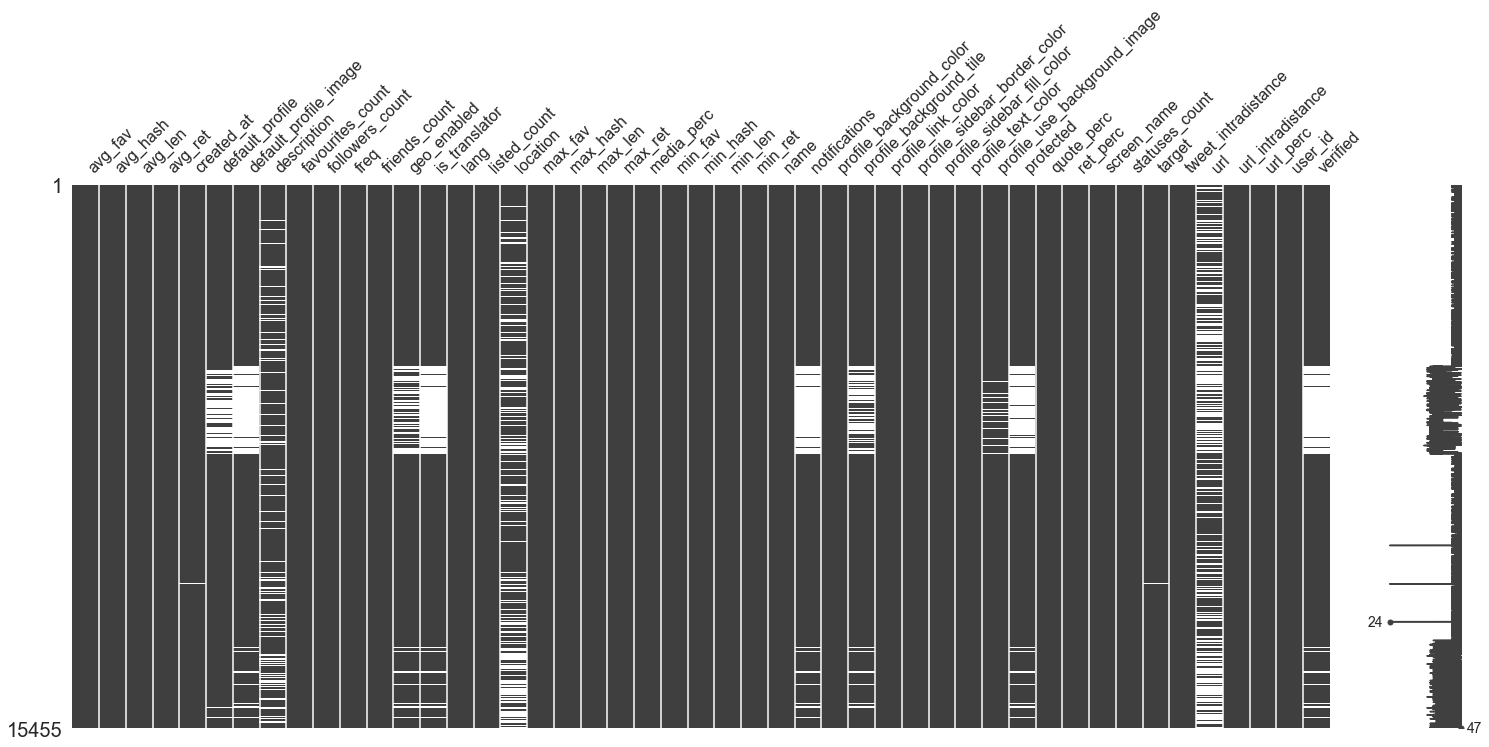

In [15]:
msno.matrix(full)

plot missing values for each target

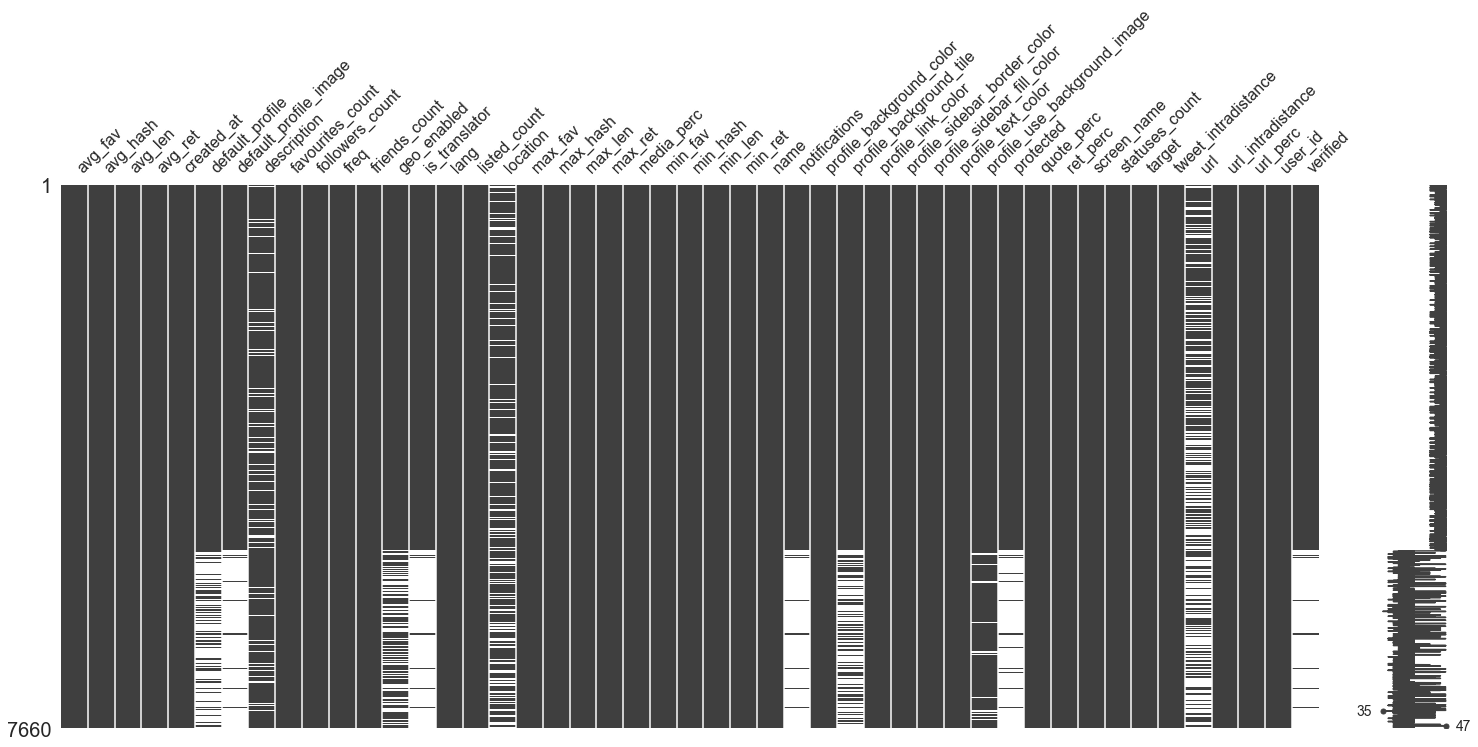

In [16]:
msno.matrix(full[full.target==0])

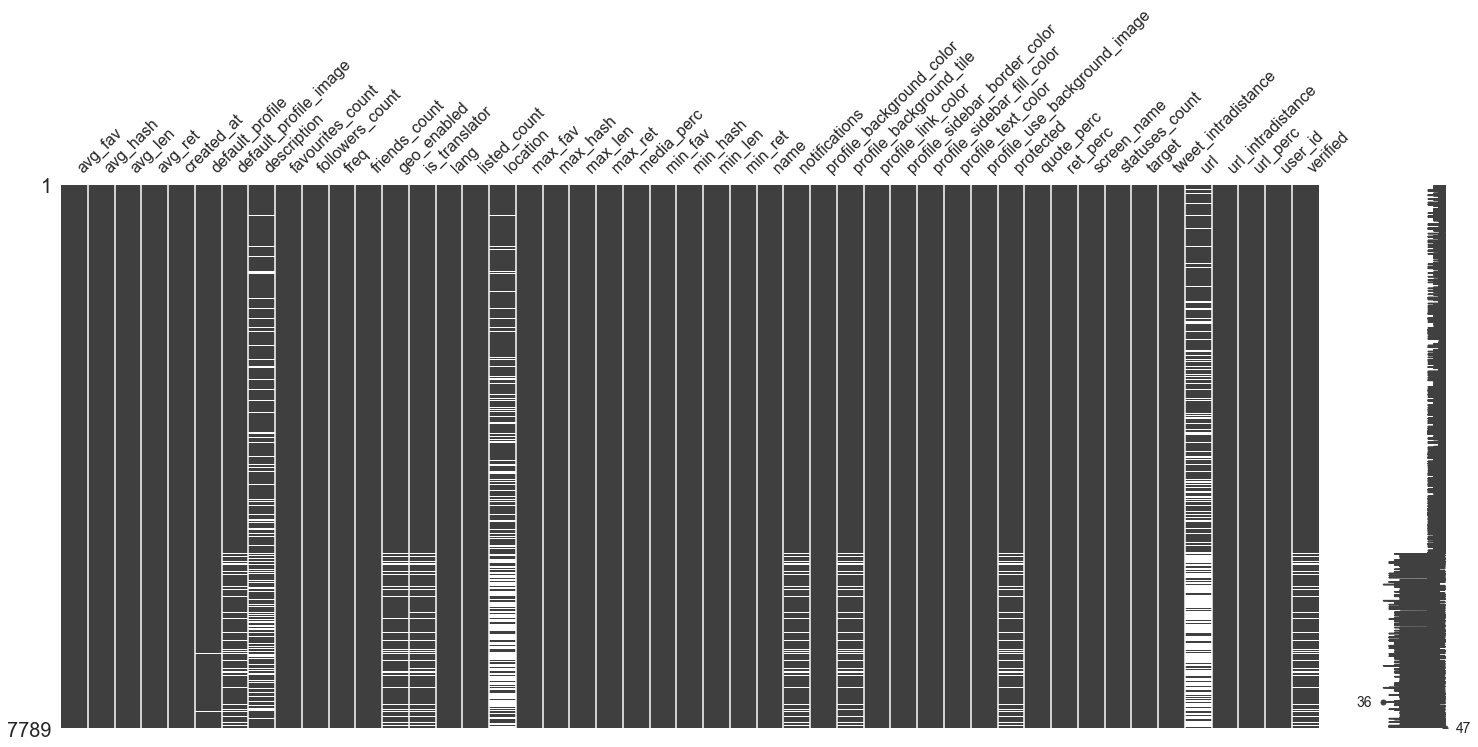

In [17]:
msno.matrix(full[full.target==1])

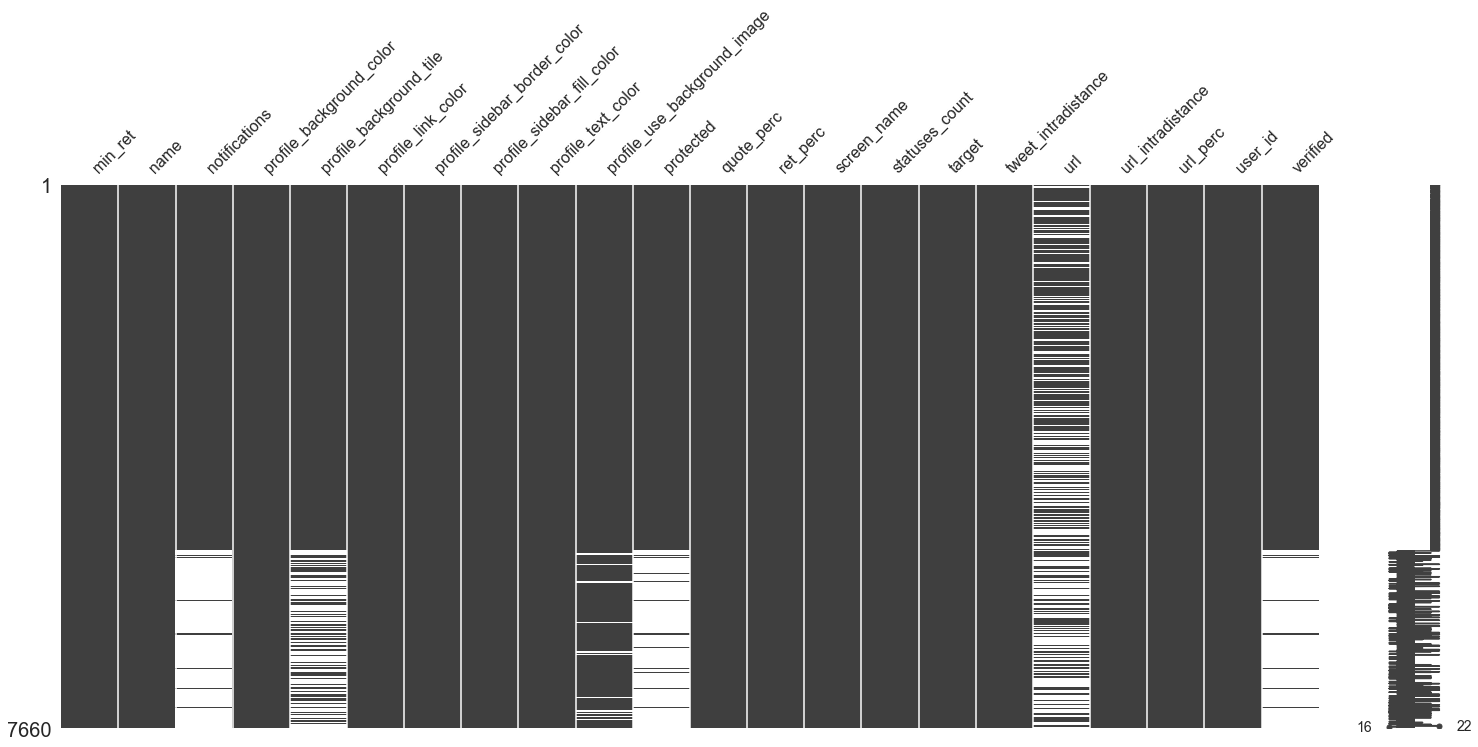

In [18]:
msno.matrix(full[full.target==0][features[25:]])

Remove features with too many missing values for some target

In [19]:
full = full.drop(columns=['default_profile_image','is_translator', 'geo_enabled', 'location', 'notifications', 'profile_background_tile', 'protected', 'verified'])

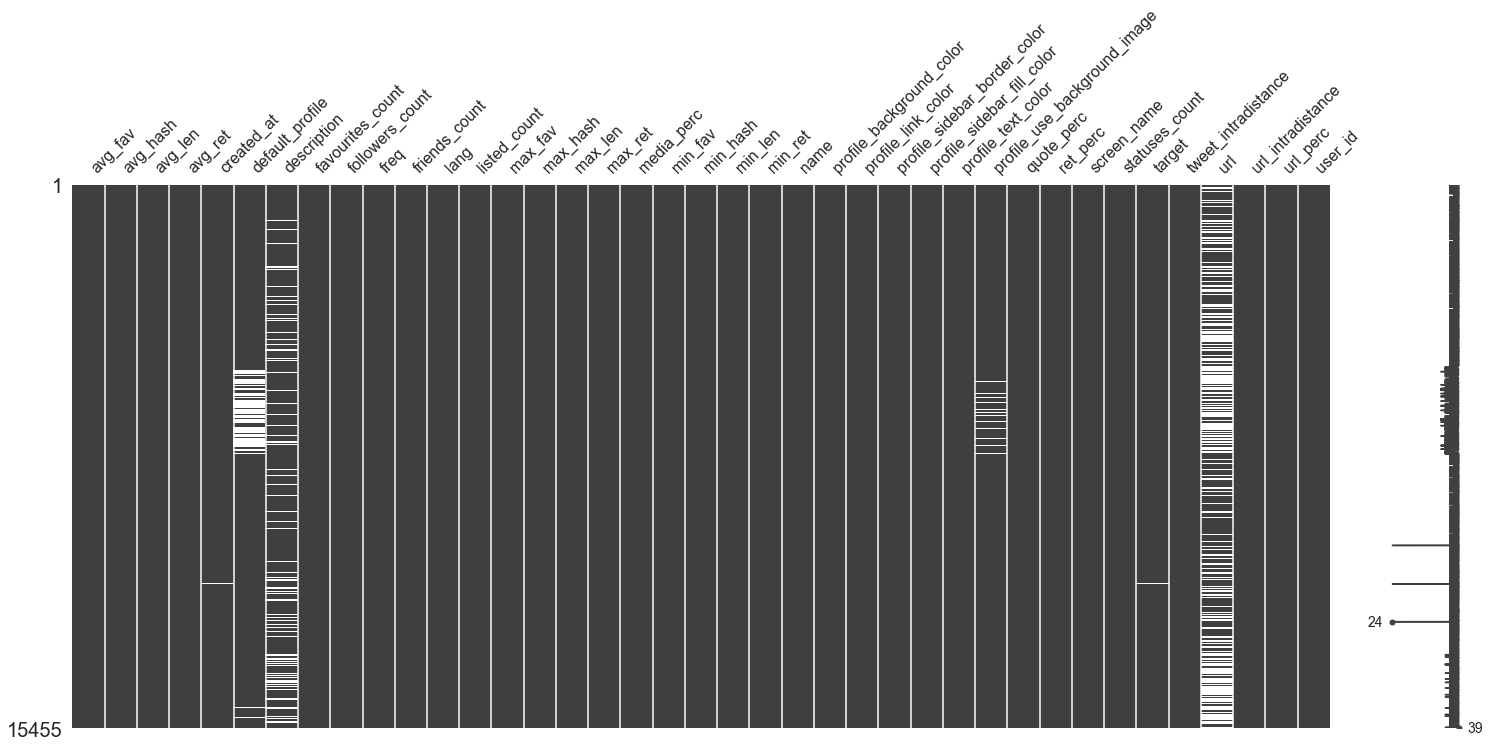

In [20]:
msno.matrix(full)

In [21]:
full.default_profile.describe()

count     13743
unique        4
top         0.0
freq       5577
Name: default_profile, dtype: object

In [22]:
full[full.target==0].default_profile.describe()

count     5982
unique       2
top        0.0
freq      4842
Name: default_profile, dtype: object

In [23]:
full[full.target==1].default_profile.describe()

count      7758
unique        4
top       False
freq       4657
Name: default_profile, dtype: object

In [24]:
full['default_profile'] = full['default_profile'].fillna(full['default_profile'].mode()[0])

In [25]:
full['description'] = full['description'].fillna('')

In [26]:
full['description_len'] = full['description'].apply(lambda x: len(x))

In [27]:
full = full.drop(columns=['description'])

In [28]:
full['name'] = full['name'].fillna('')

In [29]:
full['name_len'] = full['name'].apply(lambda x: len(x))

In [30]:
full = full.drop(columns=['name'])

In [31]:
full['screen_name'] = full['screen_name'].fillna('')

In [32]:
full['screen_name_len'] = full['screen_name'].apply(lambda x: len(x))

In [33]:
full = full.drop(columns=['screen_name'])

In [34]:
full = full.drop(columns=['lang'])

In [35]:
def oldness(x):
    if x[0] == '2':
        return 2018 - int(x[:4])
    else:
        return 2018 - int(x[-4:])

In [36]:
types = []
for elem in full['created_at']:
    types.append(type(elem))
set(types)

{float, str}

In [37]:
mask = full['created_at'].isnull()

In [38]:
full.drop(full.index[mask], inplace=True)

In [39]:
full['age'] = full['created_at'].apply(lambda x: oldness(x))

In [40]:
full = full.drop(columns=['created_at'])

In [41]:
full = full.drop(columns=['user_id'])

In [42]:
full['profile_use_background_image'][full.target==0].value_counts()

1.0    6568
0.0     825
Name: profile_use_background_image, dtype: int64

In [43]:
full['profile_use_background_image'][full.target==1].value_counts()

True     4775
1.0      2409
False     514
0.0        91
Name: profile_use_background_image, dtype: int64

In [44]:
full['profile_use_background_image'] = (full['profile_use_background_image'].notnull()).astype(int)

In [45]:
full['profile_use_background_image'] = full['profile_use_background_image'].fillna(full['profile_use_background_image'].mode()[0])

In [46]:
full['url'] = (full['url'].notnull()).astype(int)

verifico che non ci siano più missing values

In [47]:
full.isnull().astype(int).sum()

avg_fav                         0
avg_hash                        0
avg_len                         0
avg_ret                         0
default_profile                 0
favourites_count                0
followers_count                 0
freq                            0
friends_count                   0
listed_count                    0
max_fav                         0
max_hash                        0
max_len                         0
max_ret                         0
media_perc                      0
min_fav                         0
min_hash                        0
min_len                         0
min_ret                         0
profile_background_color        0
profile_link_color              0
profile_sidebar_border_color    0
profile_sidebar_fill_color      0
profile_text_color              0
profile_use_background_image    0
quote_perc                      0
ret_perc                        0
statuses_count                  0
target                          0
tweet_intradis

In [48]:
full.drop(columns=['profile_background_color', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color','profile_text_color'], inplace=True)      

In [49]:
full.describe()

,avg_fav,avg_hash,avg_len,avg_ret,favourites_count,followers_count,freq,friends_count,listed_count,max_fav,...,ret_perc,target,tweet_intradistance,url,url_intradistance,url_perc,description_len,name_len,screen_name_len,age
count,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000,1.544900e+04,15449.000000,1.544900e+04,15449.000000,15449.000000,...,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000
mean,3.098546,0.341257,81.075206,1637.531247,3825.529549,1.888786e+04,4.145435,3.594986e+03,174.119360,82.748657,...,0.178242,0.504175,10.360155,0.573047,4.149138,0.313711,72.527672,11.699463,10.653117,8.178911
std,59.248667,0.738731,44.613789,6048.715193,17169.563838,6.441881e+05,11.947256,2.891481e+04,1311.513331,2652.724015,...,0.266265,0.499999,4.773460,0.494651,3.449020,0.350924,53.455685,4.684419,2.785371,2.410402
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,0.010000,0.000000,64.130000,0.020000,2.000000,1.680000e+02,0.063291,1.950000e+02,2.000000,1.000000,...,0.000000,0.000000,10.413269,0.000000,0.000000,0.000000,25.000000,9.000000,9.000000,7.000000
50%,0.113402,0.100000,87.214286,1.420000,126.000000,7.420000e+02,0.312500,5.580000e+02,16.000000,3.000000,...,0.030000,1.000000,11.846502,1.000000,3.789268,0.163265,66.000000,12.000000,11.000000,9.000000
75%,0.500000,0.363636,108.200000,534.470000,1466.000000,3.266000e+03,2.152174,1.759000e+03,82.000000,8.000000,...,0.260417,1.000000,13.062755,1.000000,7.079361,0.540000,121.000000,14.000000,13.000000,10.000000
max,3372.340000,20.000000,299.180000,294528.510000,543756.000000,7.636714e+07,100.000000,3.003918e+06,107815.000000,234334.000000,...,1.000000,1.000000,24.269322,1.000000,9.899020,1.000000,191.000000,50.000000,15.000000,12.000000


In [50]:
full['default_profile'] = (full['default_profile'].notnull()).astype(int)
full['statuses_count'] = (full['statuses_count'].notnull()).astype(int)
full['user_id'] = (full['user_id'].notnull()).astype(int)

In [69]:
full.to_csv('data/bot_or_not/full_preproc_train.csv')

# riparti da qui per evitare preprocessing

In [57]:
full = pd.read_csv('data/bot_or_not/full_preproc_train.csv')

In [62]:
full.columns

Index(['avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'default_profile',
       'favourites_count', 'followers_count', 'freq', 'friends_count',
       'listed_count', 'max_fav', 'max_hash', 'max_len', 'max_ret',
       'media_perc', 'min_fav', 'min_hash', 'min_len', 'min_ret',
       'profile_use_background_image', 'quote_perc', 'ret_perc',
       'statuses_count', 'target', 'tweet_intradistance', 'url',
       'url_intradistance', 'url_perc', 'user_id', 'description_len',
       'name_len', 'screen_name_len', 'age'],
      dtype='object')

In [65]:
def predict(X, y, n_trees=10, max_depth=None, knn=10):
    
    forest = RandomForestClassifier(n_estimators = n_trees, max_depth=max_depth, criterion = 'entropy', random_state = 42)
    logreg = linear_model.LogisticRegression()
    
    scaler = MinMaxScaler()
    X_n = scaler.fit_transform(X)
    knn = KNeighborsClassifier(n_neighbors=knn)
    SVM = svm.SVC()
    scoring = ['f1', 'precision', 'recall', 'roc_auc']
    scores = []
    scores.append(cross_validate(forest, X, y, cv=10, scoring=scoring))
    scores.append(cross_validate(logreg, X, y, cv=10, scoring=scoring))
    scores.append(cross_validate(knn, X_n, y, cv=10, scoring=scoring))
    scores.append(cross_validate(SVM, X, y, cv=10, scoring=scoring))
    
    return scores

In [63]:
# split X,y
X = full.drop(columns=['target', 'user_id'])
y = full['target']

In [64]:
X.columns

Index(['avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'default_profile',
       'favourites_count', 'followers_count', 'freq', 'friends_count',
       'listed_count', 'max_fav', 'max_hash', 'max_len', 'max_ret',
       'media_perc', 'min_fav', 'min_hash', 'min_len', 'min_ret',
       'profile_use_background_image', 'quote_perc', 'ret_perc',
       'statuses_count', 'tweet_intradistance', 'url', 'url_intradistance',
       'url_perc', 'description_len', 'name_len', 'screen_name_len', 'age'],
      dtype='object')

In [66]:
baselines = predict(X,y)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, incr

## RF scores:

In [67]:
print("F1:")
print(baselines[0]['test_f1'].mean())
print("Precision:")
print(baselines[0]['test_precision'].mean())
print("Recall:")
print(baselines[0]['test_recall'].mean())
print("AUC:")
print(baselines[0]['test_roc_auc'].mean())

F1:
0.8248295946767294
Precision:
0.879956066443334
Recall:
0.79318419567635
AUC:
0.9164290790962774


## LogReg Scores:

In [68]:
print("F1:")
print(baselines[1]['test_f1'].mean())
print("Precision:")
print(baselines[1]['test_precision'].mean())
print("Recall:")
print(baselines[1]['test_recall'].mean())
print("AUC:")
print(baselines[1]['test_roc_auc'].mean())

F1:
0.7230511496774226
Precision:
0.6941525747544804
Recall:
0.7591455989651223
AUC:
0.7926749008686158


## KNN scores:

In [69]:
print("F1:")
print(baselines[2]['test_f1'].mean())
print("Precision:")
print(baselines[2]['test_precision'].mean())
print("Recall:")
print(baselines[2]['test_recall'].mean())
print("AUC:")
print(baselines[2]['test_roc_auc'].mean())

F1:
0.7606496400243804
Precision:
0.7791158731288068
Recall:
0.7501740745996284
AUC:
0.8351536218196463


## SVM scores:

In [70]:
print("F1:")
print(baselines[3]['test_f1'].mean())
print("Precision:")
print(baselines[3]['test_precision'].mean())
print("Recall:")
print(baselines[3]['test_recall'].mean())
print("AUC:")
print(baselines[3]['test_roc_auc'].mean())

F1:
0.150194651213064
Precision:
0.6200294784580499
Recall:
0.09592995436110496
AUC:
0.5839701952138514


# Grid Search

In [209]:
def grid_search(X, y, model, params):
    
    scoring = ['roc_auc']
    grid = GridSearchCV(model, params, cv=10, scoring=scoring, refit=False)
    grid.fit(X, y)
    
    return grid

### Random Forest

In [ ]:
params = {'n_estimators':[115,130,150,175,200,250], 'max_depth':[24,26,28], 'criterion':['entropy']}
model = RandomForestClassifier()

rf_grid = grid_search(X, y, model, params)

In [ ]:
n_estimators = list(set(pd.DataFrame(rf_grid.cv_results_).param_n_estimators))
max_depth = list(set(pd.DataFrame(rf_grid.cv_results_).param_max_depth))

In [121]:
best_auc = results.sort_values(by=['mean_test_roc_auc'], ascending=False)[:5]

In [152]:
best_auc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_f1,split1_test_f1,...,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,split5_train_roc_auc,split6_train_roc_auc,split7_train_roc_auc,split8_train_roc_auc,split9_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
19,4.284353,0.392268,0.163540,0.045596,entropy,24,70,"{'criterion': 'entropy', 'max_depth': 24, 'n_e...",0.652027,0.855808,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.941298e-08
23,5.236936,1.318476,0.229853,0.089296,entropy,26,70,"{'criterion': 'entropy', 'max_depth': 26, 'n_e...",0.664424,0.852724,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.276957e-09
26,2.571281,0.069752,0.098057,0.009368,entropy,28,60,"{'criterion': 'entropy', 'max_depth': 28, 'n_e...",0.643164,0.848363,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.707859e-08
18,3.353237,0.284468,0.137601,0.042103,entropy,24,60,"{'criterion': 'entropy', 'max_depth': 24, 'n_e...",0.639725,0.860013,...,1.0,0.999999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.722861e-07
31,2.914720,0.042446,0.114068,0.007848,entropy,30,70,"{'criterion': 'entropy', 'max_depth': 30, 'n_e...",0.662174,0.858871,...,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.965068e-17


## Visualize Results

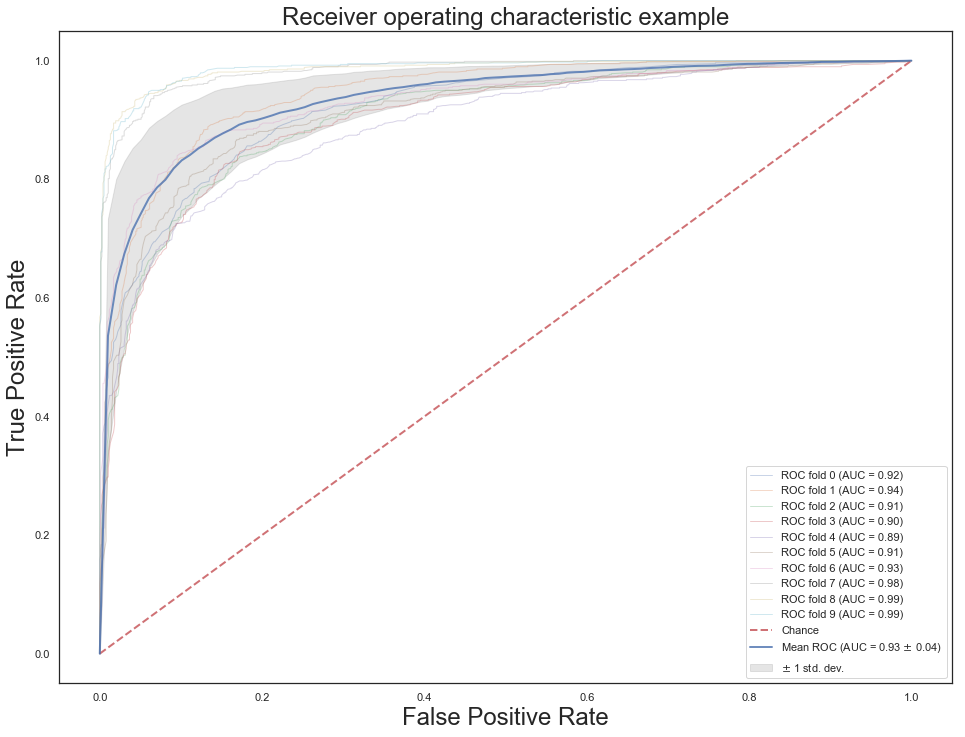

In [316]:
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = RandomForestClassifier(n_estimators=175, criterion='entropy', max_depth=24)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(16,12))

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('data/bot_or_not/auc.png')
plt.show()

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_roc_auc']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_roc_auc']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    fig, ax = plt.subplots(1,1, figsize=(16,12))
    

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(sorted(grid_param_1), scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=24)
    ax.set_xlabel(name_param_1, fontsize=24)
    ax.set_ylabel('AUC Average Score', fontsize=24)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    fig.savefig('data/bot_or_not/gridSearch.png')

In [ ]:
plot_grid_search(rf_grid.cv_results_, n_estimators, max_depth, 'N Estimators', 'Max Depth')

In [328]:
res[['param_n_estimators','param_max_depth','mean_test_roc_auc']]

,param_n_estimators,param_max_depth,mean_test_roc_auc
0,100,26,0.934564
1,115,26,0.935791
2,130,26,0.935579
3,150,26,0.935655
4,175,26,0.936254
5,200,26,0.936061
6,250,26,0.936070
7,100,28,0.935252
8,115,28,0.934419
9,130,28,0.935543


### Max depth tuning

In [306]:
import time
start = time.time()
model = RandomForestClassifier(n_estimators=175, criterion='entropy', max_depth=24)
model.fit(X,y)
end = time.time()
print("Fitting time: " + str(end - start))

Fitting time: 8.05405592918396


In [307]:
start = time.time()
model.predict_proba(np.array(X.iloc[0]).reshape(1, -1))
end = time.time()
print("Prediction time: " + str(end - start))

Prediction time: 0.021600008010864258


In [244]:
pickle.dump(model, open("data/bot_or_not/model.model", "wb"))

In [245]:
pickle.dump(model, open("../scripts/bot_or_not.model", "wb"))